[Dataset](https://vision.middlebury.edu/stereo/data/)


In [2]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [5]:
# Some helper functions
def to_homogeneous(coordinates):
    # Add a column of ones to the coordinates to make them homogeneous
    return np.hstack((coordinates, np.ones((coordinates.shape[0], 1))))
    
def from_homogeneous(coordinates):
    # Divide the first two columns by the third column to obtain non-homogeneous coordinates
    return coordinates[:, :2] / coordinates[:, 2][:, None]
# Function to plot a camera plane in 3D
def plot_camera_plane(ax, R, T, scale=0.5, color='blue', label='Camera'):
    # Define the camera plane corners in the camera's local coordinate system
    camera_corners = np.array([
        [-1, -1, 1],
        [ 1, -1, 1],
        [ 1,  1, 1],
        [-1,  1, 1],
        [-1, -1, 1]
    ]) * scale
    # Transform corners to world coordinates
    transformed_corners = (R @ camera_corners.T + T.reshape(3, 1)).T
    # Plot the camera plane as a polygon and mark the optical center
    ax.plot(*transformed_corners[:5, :].T, color=color, linestyle='-', label=label + " Plane")

# Essential Matrix
The essential matrix is a fundamental concept in computer vision, particularly in stereo vision and structure from motion (SfM). It represents the relationship between corresponding points in two images of a scene taken from different viewpoints.

Essentially, the essential matrix encapsulates the relative pose (orientation and position) of the cameras capturing the images. It encodes geometric constraints such as epipolar geometry, which describes how points in one image correspond to lines (epipolar lines) in the other image.

The essential matrix is crucial for tasks like stereo matching, image rectification, and 3D reconstruction, as it provides the geometric information needed to compute depth and structure from multiple views.

In the implementation below, we are assuming that we have a canonical camera (intrinsic parameters matrix K is indentity matrix)

In [14]:
img1 = cv.imread('./data/images/left1.jpg', cv.IMREAD_GRAYSCALE) 
img2 = cv.imread('./data/images/right1.jpg', cv.IMREAD_GRAYSCALE) 
 
sift = cv.SIFT_create() 
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
 
# Create BFMatcher (Brute Force Matcher)
bf = cv.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)

pts1 = []
pts2 = [] 
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
 if m.distance < 0.75*n.distance:
     pts1.append(kp1[m.queryIdx].pt)
     pts2.append(kp2[m.trainIdx].pt)
     
pts1 = np.array(pts1)
pts2 = np.array(pts2)

In [15]:
# Finding essential matrix
K = np.eye(3) # assuming canonical camera (intrinsic parameters matrix K is indentity matrix)
E, mask = cv.findEssentialMat(pts1, pts2, K, cv.RANSAC)
R1, R2, t = cv.decomposeEssentialMat(E) # decomposing the essential matrix to rotation matrices and translation

# Fundamental Matrix
The fundamental matrix is another fundamental concept in computer vision, particularly in stereo vision and multiple view geometry. It describes the geometric relationship between corresponding points in two images of a scene taken from different viewpoints, without the need for knowledge of the camera intrinsic parameters as it inherently encapsulates such information

$F = K_2^{-T} E K_1^{-1}$, where $K_1$ and $K_2$ are the intrinsic parameter matrix for camera 1 and camera 2

In [16]:
# Finding Fundamental matrix
F, mask = cv.findFundamentalMat(pts1, pts2, cv.RANSAC)

# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

### Computing the Epipolar 

Fundametal matix/Essential matrix map points in one images to epipolar lines in the other image:

$ l = F \cdot p $

Where:
- $ l $ is the epipolar line.
- $F $ is the fundamental matrix.
- $p$ is a point in one image.

The equation of a line in 2D can be represented as:

$ ax + by + c = 0$

Given a line in this form, we can find two points on this line that lie on the image boundary by setting one of the coordinates to either 0 or the width/height of the image (depending on which boundary we want to intersect). Then, we solve for the other coordinate.

In Python code, this process is implemented as follows:

```python
# Find a point on the left boundary (x = 0)
y0 = -c / b

# Find a point on the right boundary (x = image.shape[1])
y1 = (-c - a * image.shape[1]) / b
```

These points (0, \( y_0 \)) and (\( width \), \( y_1 \)) are the two points on the epipolar line that lie on the image boundary.

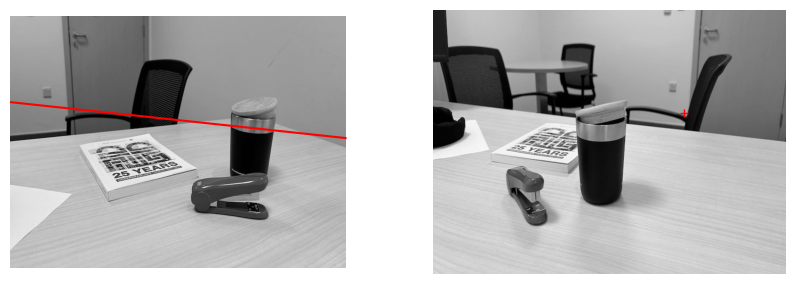

In [17]:
#cv.computeCorrespondEpilines(pts2, 2, F)

lines1 = to_homogeneous(pts2).dot(F)

r,c = img1.shape

pts_index = 8

# Plots
a = lines1[pts_index, 0]
b = lines1[pts_index, 1]
c = lines1[pts_index, 2]

plt.figure(figsize=(10,6))
plt.subplot(121),plt.imshow(img1, cmap='gray'), plt.axis('off')
#img1color = cv.line(cv.cvtColor(img1, cv.COLOR_GRAY2BGR), (0, int(y0)), (640, int(y1)), [0,0,255], 1) # to draw the epipolar line on the image itself
y0 = -c/b
y1 = (- c - a * img1.shape[1]) / b
plt.plot([0, img1.shape[1]], [y0, y1], 'r')

plt.subplot(122),plt.imshow(img2, cmap='gray'), plt.axis('off')
plt.plot(pts2[pts_index,0], pts2[pts_index,1], 'r+')

plt.show()

# Structure from Motion
Structure from Motion (SfM) is a technique in computer vision that reconstructs the 3D structure of a scene from a sequence of 2D images taken from different viewpoints


## Toy Problem

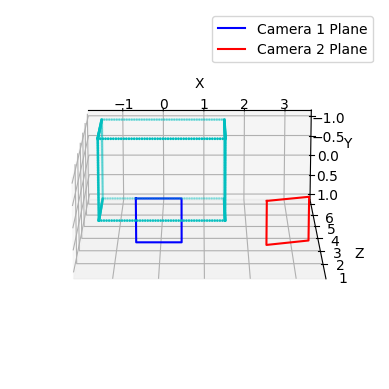

In [6]:
# Define cuboid dimensions and center
width, height, depth = 3, 2, 2
center = np.array([0, 0, 5])
num_points = 50  # Number of points to place along each edge
# Calculate half-dimensions
w, h, d = width / 2, height / 2, depth / 2
# Define the 8 corners of the cuboid
corners = np.array([
    [center[0] - w, center[1] - h, center[2] - d],
    [center[0] + w, center[1] - h, center[2] - d],
    [center[0] + w, center[1] + h, center[2] - d],
    [center[0] - w, center[1] + h, center[2] - d],
    [center[0] - w, center[1] - h, center[2] + d],
    [center[0] + w, center[1] - h, center[2] + d],
    [center[0] + w, center[1] + h, center[2] + d],
    [center[0] - w, center[1] + h, center[2] + d]
])
# Define pairs of corners that form the edges
edges = [
    (0, 1), (1, 2), (2, 3), (3, 0),  # Bottom face
    (4, 5), (5, 6), (6, 7), (7, 4),  # Top face
    (0, 4), (1, 5), (2, 6), (3, 7)   # Vertical edges
]
# Collect all points along the edges
points = []
for edge in edges:
    start, end = corners[edge[0]], corners[edge[1]]
    for t in np.linspace(0, 1, num_points):
        point = (1 - t) * start + t * end  # Linear interpolation
        points.append(point)
X = np.array(points)

### -----------------------
X = to_homogeneous(X)

# Define the two projection matrices corresponding to two cameras
M1 = np.hstack((np.eye(3), np.zeros((3, 1))))

theta = -20 * (np.pi / 180)
R = np.array([
        [np.cos(theta), 0, np.sin(theta)],
        [0, 1, 0],
        [-np.sin(theta), 0, np.cos(theta)]])
T = np.array([3,0,0]).reshape((3,1))
M2 = np.hstack((R.T,-R.T@T))

# Camera 
U1 = np.eye(4)
U2 = np.vstack( ( (np.hstack((R,T))), np.array([0,0,0,1])) )

# Plot the translated point cloud
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], s=1, color='c')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plot_camera_plane(ax, np.eye(3), np.array([0, 0, 0]), scale=.5, color='blue', label='Camera 1')
plot_camera_plane(ax, R, T, scale=.5, color='red', label='Camera 2')
ax.legend()

ax.view_init(elev=-75, azim=-90)
ax.set_aspect('equal')
plt.show()

([<matplotlib.lines.Line2D at 0x163f3fe50>],
 (-0.572162036230643,
  0.13668504375470988,
  -0.2575026499904314,
  0.2575026499904314))

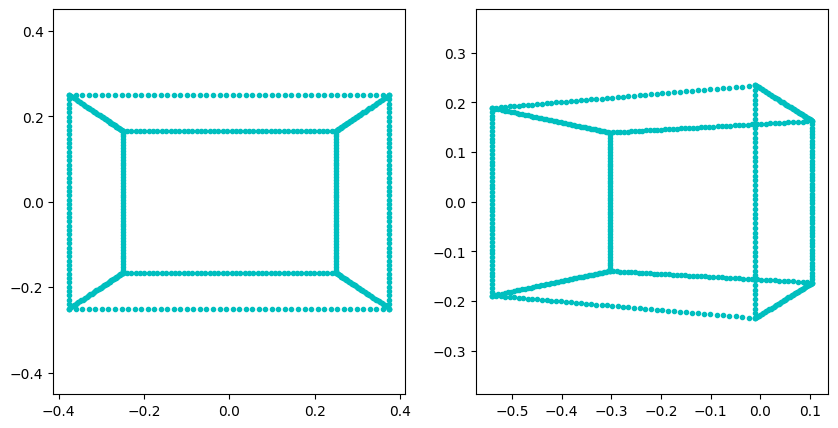

In [8]:
# Projection on the two cameras
pts1 = from_homogeneous(X @ M1.T)
pts2 = from_homogeneous(X @ M2.T)

fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(pts1[:,0], pts1[:,1], 'c.'), plt.axis('equal')
plt.subplot(1,2,2)
plt.plot(pts2[:,0], pts2[:,1], 'c.'), plt.axis('equal')

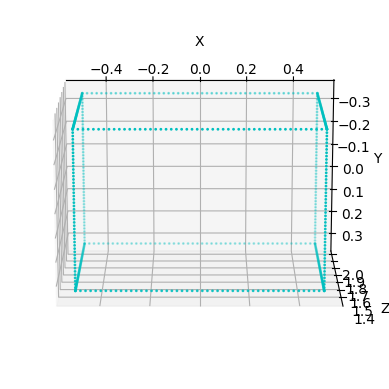

In [9]:
E, mask = cv.findFundamentalMat(pts1, pts2, cv.FM_8POINT)
_, R_, T_, mask= cv.recoverPose(E, pts1, pts2)

# Projection matrix for the second camera. 
M2_ = np.hstack((R_,T_))

pts_4d_hom = cv.triangulatePoints(M1, M2_, pts1.T, pts2.T)
pts_3d = pts_4d_hom[:3] / pts_4d_hom[3]  
pts_3d = pts_3d.T

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pts_3d[:, 0], pts_3d[:, 1], pts_3d[:, 2], s=1, color='c')
ax.set_xlabel('X'), ax.set_ylabel('Y'), ax.set_zlabel('Z')
ax.view_init(elev=-75, azim=-90)
ax.set_aspect("equal")

## 3D reconstruction from two images 

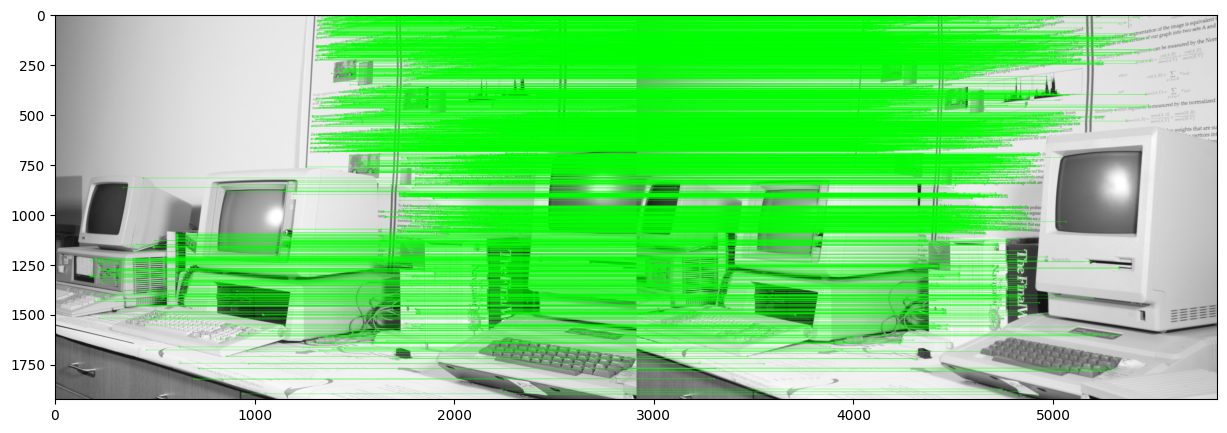

(<matplotlib.image.AxesImage at 0x164508af0>, None)

In [18]:
# Intrinsic parameters of the two cameras
K1=np.array([[3989.963, 0, 1039.414], [0, 3989.963, 956.875], [0, 0, 1]])
K2=np.array([[3989.963, 0, 1194.824], [0, 3989.963, 956.875], [0, 0, 1]])

img1 = cv.imread('./data/images/comp0.png', cv.IMREAD_GRAYSCALE) 
img2 = cv.imread('./data/images/comp1.png', cv.IMREAD_GRAYSCALE) 

sift = cv.SIFT_create() 
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
 
# Create BFMatcher (Brute Force Matcher)
bf = cv.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)

pts1 = []
pts2 = [] 
good = []
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
 if m.distance < 0.7*n.distance:
     pts1.append(kp1[m.queryIdx].pt)
     pts2.append(kp2[m.trainIdx].pt)
     good.append(m)
     
pts1 = np.array(pts1)
pts2 = np.array(pts2)

# Finding Fundamental matrix
F, mask = cv.findFundamentalMat(pts1, pts2, cv.RANSAC)

# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

# Draw the matching 
#draw_params = dict(matchColor = (0,255,0), # draw matches in green color
#                   singlePointColor = None,
#                   matchesMask = mask.ravel().tolist(), # draw only inliers
#                   flags = cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
#plt.figure(figsize=(15,15))
#output_image = cv.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
#plt.imshow(cv.cvtColor(output_image, cv.COLOR_BGR2RGB)), plt.show()

In [11]:
E = K2.T @ F @ K1

upts1 = cv.undistortPoints(pts1, K1, None).squeeze(1)
upts2 = cv.undistortPoints(pts2, K2, None).squeeze(1)
# Recover R, T withrespect to the first camera
_, R, T, mask = cv.recoverPose(E, upts1, upts2)

# Projection matrix for the first camera (assuming it is K1[I|0])
M1 = K1 @ np.hstack((np.eye(3), np.zeros((3, 1))))

# Projection matrix for the second camera K2[R|T]
M2 = K2 @ np.hstack((R, T))

# Perform triangulation
pts_4d_hom = cv.triangulatePoints(M1, M2, pts1[mask.ravel()==255].T, pts2[mask.ravel()==255].T)

# Convert from homogeneous coordinates to 3D
pts_3d = pts_4d_hom[:3] / pts_4d_hom[3]
pts_3d = pts_3d.T

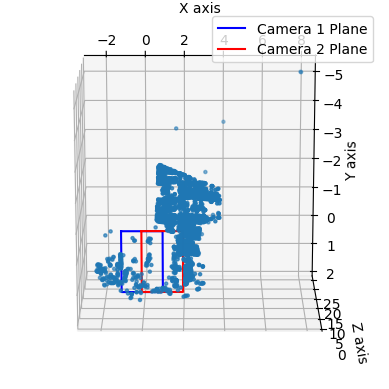

In [12]:
# Set up the 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the camera plane
plot_camera_plane(ax, np.eye(3), np.array([0, 0, 0]), scale=1, color='blue', label='Camera 1')
plot_camera_plane(ax, R.T, -R.T@T, scale=1, color='red', label='Camera 2')

ax.scatter(pts_3d[:,0], pts_3d[:,1], pts_3d[:,2], marker='.')

# Label axes and set plot limits
ax.set_xlabel("X axis"), ax.set_ylabel("Y axis"), ax.set_zlabel("Z axis")
ax.legend()

ax.view_init(elev=-75, azim=-90)
plt.show()


# Dense Reconstruction

## Image Rectification
Rectification is the process of finding two Homographies that make stereo images parallel, which meanstThe epipolar lines in the two images become parallel horizontal lines, all having the same y-coordinate


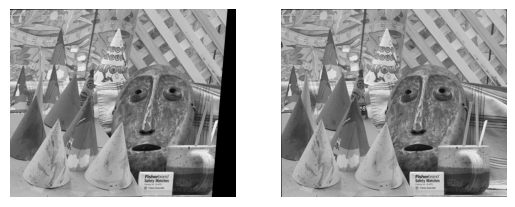

In [11]:
img1 = cv.imread('./data/images/left2.png', cv.IMREAD_GRAYSCALE) 
img2 = cv.imread('./data/images/right2.png', cv.IMREAD_GRAYSCALE) 

sift = cv.SIFT_create() 
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
 
# Create BFMatcher (Brute Force Matcher)
bf = cv.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)

pts1 = []
pts2 = [] 
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
 if m.distance < 0.8*n.distance:
     pts1.append(kp1[m.queryIdx].pt)
     pts2.append(kp2[m.trainIdx].pt)

# Finding Fundamental matrix
pts1_ = np.array(pts1)
pts2_ = np.array(pts2)
F, mask = cv.findFundamentalMat(pts1_, pts2_, cv.RANSAC)

# We select only inlier points
pts1_ = pts1_[mask.ravel()==1]
pts2_ = pts2_[mask.ravel()==1]

h,w = img1.shape
# find the two homographies
_, H1, H2 = cv.stereoRectifyUncalibrated(pts1_, pts2_, F, (w,h))
# Appling the two homographies to the two images to rectify them
rectified_img1 = cv.warpPerspective(img1, H1, (w,h), flags=cv.INTER_LINEAR)
rectified_img2 = cv.warpPerspective(img2, H2, (w,h), flags=cv.INTER_LINEAR)


# Plots
plt.subplot(121),plt.imshow(rectified_img1, cmap='gray'), plt.axis('off')
plt.subplot(122),plt.imshow(rectified_img2, cmap='gray'), plt.axis('off')
plt.show()

# Depth Map
[Additional Reading](https://docs.opencv.org/4.x/dd/d53/tutorial_py_depthmap.html)

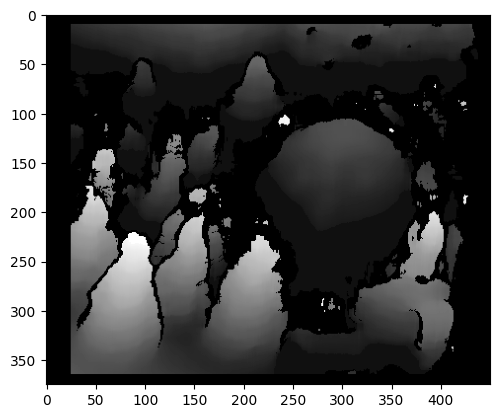

In [360]:
stereo = cv.StereoBM_create(numDisparities=16, blockSize=21)
disparity = stereo.compute(rectified_img1,rectified_img2)
plt.imshow(disparity,'gray')